In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table
from tqdm import tqdm

In [2]:
class GridWorld:
    def __init__(self, world_size: int=4, action_prob: float=0.25):
        self.world_size = world_size
        self.actions = [
            np.array([0, -1]),  # left
            np.array([-1, 0]),  # up
            np.array([0, 1]),   # right
            np.array([1, 0])    # down
        ]
        self.action_prob = action_prob
        self.reset_logs()

    def is_terminal(self, state: list[int]):
        """Terminal state: (0, 0) or (world_size - 1, world_size - 1)
        - state: is coordinate of the grid: x, y
        """
        x, y = state
        return (x == 0 and y == 0) or (x == self.world_size - 1 and y == self.world_size - 1)
    
    def reset_logs(self):
        self.logs = []

    def step(self, state: list[int], action: np.ndarray):
        """Deterministic state transition function"""
        if self.is_terminal(state):
            return state, 0

        next_state = (np.array(state) + action).tolist()
        x, y = next_state

        # case: out of grid
        if x < 0 or x >= self.world_size or y < 0 or y >= self.world_size:
            next_state = state

        reward = -1
        return next_state, reward

    def iterative_policy_iteration(self, in_place=True, discount=1.0, log=False, threshold=1e-6):
        # initialize states
        new_state_values = np.zeros((self.world_size, self.world_size))
        if log:
            self.reset_logs()
            
        iteration = 0
        global_iterator = tqdm(desc=f'Global I = {iteration}')
        while True:
            if in_place:
                state_values = new_state_values
            else:
                state_values = new_state_values.copy()
            if log:
                log_dict = {'state': new_state_values.copy(), 'policy': np.zeros((self.world_size*self.world_size, len(self.actions)))}
            # copy current state values: v <- V(s)
            old_state_values = state_values.copy()
            # calculate state values for each state: s \in S
            iterator = tqdm(range(self.world_size*self.world_size), leave=False)
            for k in iterator:
                i, j = k // self.world_size, k % self.world_size
                iterator.set_description(f'[I = {iteration}] ({i}, {j})')
                value = 0
                # \sum_a \pi(a|s) \sum_{s', r} p(s', r|s, a) [r + \gamma V(s')]
                for act_index, action in enumerate(self.actions):
                    (next_i, next_j), reward = self.step([i, j], action)
                    q_pi = reward + discount * state_values[next_i, next_j]
                    value += self.action_prob * q_pi
                    if log:
                        log_dict['policy'][k, act_index] = q_pi
                new_state_values[i, j] = value
            # log states
            if log:
                self.logs.append(log_dict)
            # delta <- max_s |v - V(s)|
            max_delta_value = abs(old_state_values - new_state_values).max()
            if max_delta_value < threshold:
                break

            iteration += 1
            # update iterators
            iterator.close()
            global_iterator.update(1)
            global_iterator.set_description(f'Global I = {iteration}')

        return new_state_values, iteration


In [3]:
WORLD_SIZE = 4
ACTION_PROB = 0.25
grid_world = GridWorld(
    world_size=WORLD_SIZE,
    action_prob=ACTION_PROB
)

In [4]:
values, sync_iteration = grid_world.iterative_policy_iteration(in_place=False, discount=1.0, log=True)

Global I = 257: : 257it [00:07, 35.13it/s]


In [5]:
def draw_values_policy(grid_world, log_index):
    logs = grid_world.logs[log_index]
    values = logs['state']
    policy = logs['policy']
    mask_matrix = policy == policy.max(axis=1)[:, None]  # greedy policy

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
    ax1, ax2 = axes
    empty_matrix = np.zeros((WORLD_SIZE, WORLD_SIZE))
    # ax1.axis('off')
    # ax2.axis('off')
    sns.heatmap(values, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax1, linewidths=1, linecolor='black')
    sns.heatmap(empty_matrix, annot=False, fmt='.2f', cmap='Blues', cbar=False, ax=ax2, linewidths=1, linecolor='black')
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            if (i == 0 and j == 0) or (i == WORLD_SIZE-1 and j == WORLD_SIZE-1):
                continue
            # draw policy
            mask = mask_matrix[i*WORLD_SIZE + j, :]  # check if multiple best results
            for k in range(len(grid_world.actions)):
                if mask[k]:
                    dx, dy = grid_world.actions[k]
                    ax2.arrow(i+.5, j+.5, dx/2, dy/2, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
    ax1.set_title('State values $V(s)$')
    ax2.set_title('Policy $\pi$')
    for ax in axes:
        ax.xaxis.set_label_position('top')
    fig.suptitle(f'Iteration {log_index}')

    return fig


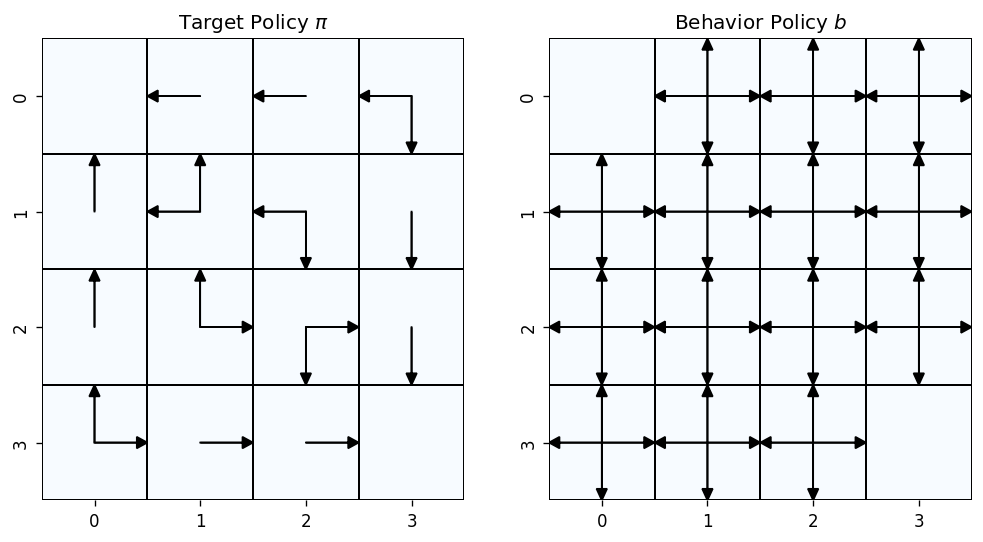

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
ax1, ax2 = axes
logs_first, logs_last = grid_world.logs[0], grid_world.logs[-1]
policy_first, policy_last = logs_first['policy'], logs_last['policy']
mask_matrix_first = policy_first == policy_first.max(axis=1)[:, None]  # greedy policy
mask_matrix_last = policy_last == policy_last.max(axis=1)[:, None]  # greedy policy
empty_matrix = np.zeros((WORLD_SIZE, WORLD_SIZE))
sns.heatmap(empty_matrix, annot=False, fmt='.2f', cmap='Blues', cbar=False, ax=ax1, linewidths=1, linecolor='black')
for i in range(WORLD_SIZE):
    for j in range(WORLD_SIZE):
        if (i == 0 and j == 0) or (i == WORLD_SIZE-1 and j == WORLD_SIZE-1):
            continue
        # draw policy
        mask = mask_matrix_last[i*WORLD_SIZE + j, :]  # check if multiple best results
        for k in range(len(grid_world.actions)):
            if mask[k]:
                dx, dy = grid_world.actions[k]
                ax1.arrow(i+.5, j+.5, dx/2, dy/2, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)

sns.heatmap(empty_matrix, annot=False, fmt='.2f', cmap='Blues', cbar=False, ax=ax2, linewidths=1, linecolor='black')
for i in range(WORLD_SIZE):
    for j in range(WORLD_SIZE):
        if (i == 0 and j == 0) or (i == WORLD_SIZE-1 and j == WORLD_SIZE-1):
            continue
        # draw policy
        mask = mask_matrix_first[i*WORLD_SIZE + j, :]  # check if multiple best results
        for k in range(len(grid_world.actions)):
            if mask[k]:
                dx, dy = grid_world.actions[k]
                ax2.arrow(i+.5, j+.5, dx/2, dy/2, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)

for ax in axes:
    ax.xaxis.set_label_position('top')
ax1.set_title('Target Policy $\pi$')
ax2.set_title('Behavior Policy $b$')
plt.show()

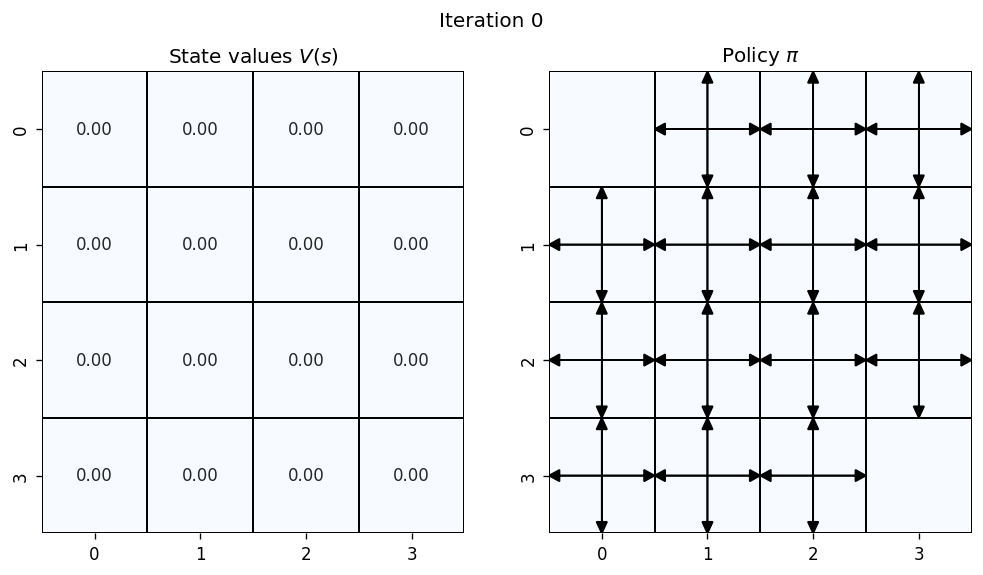

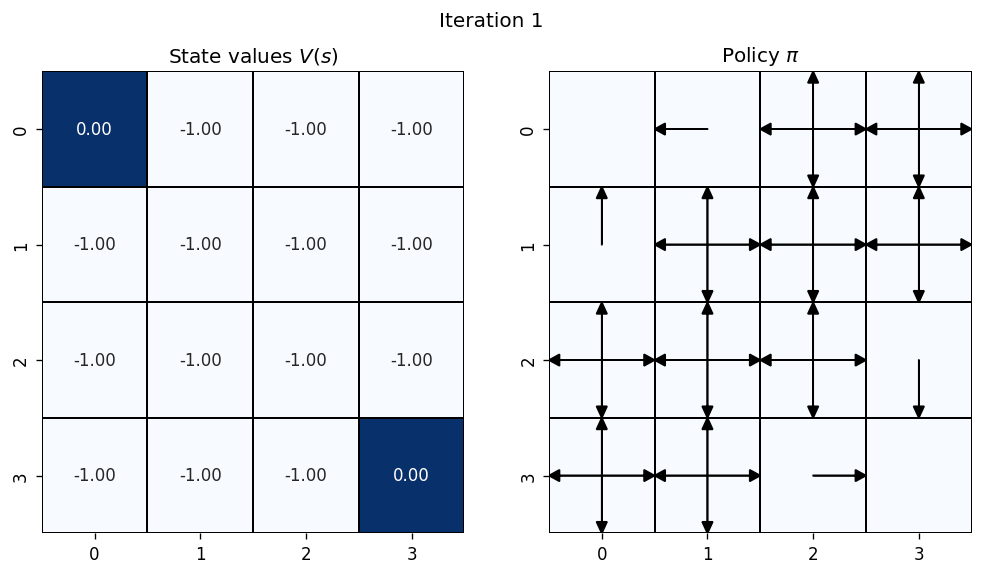

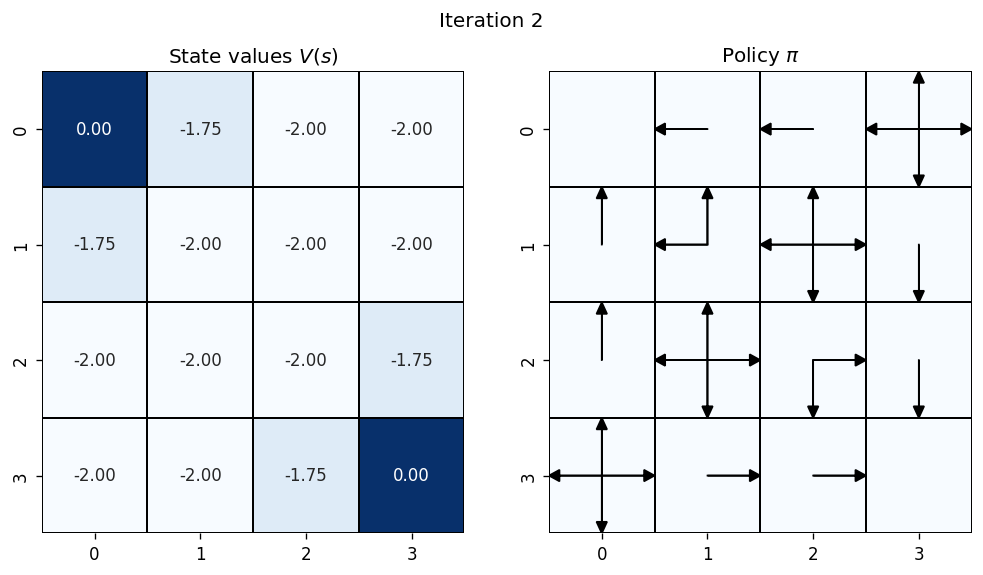

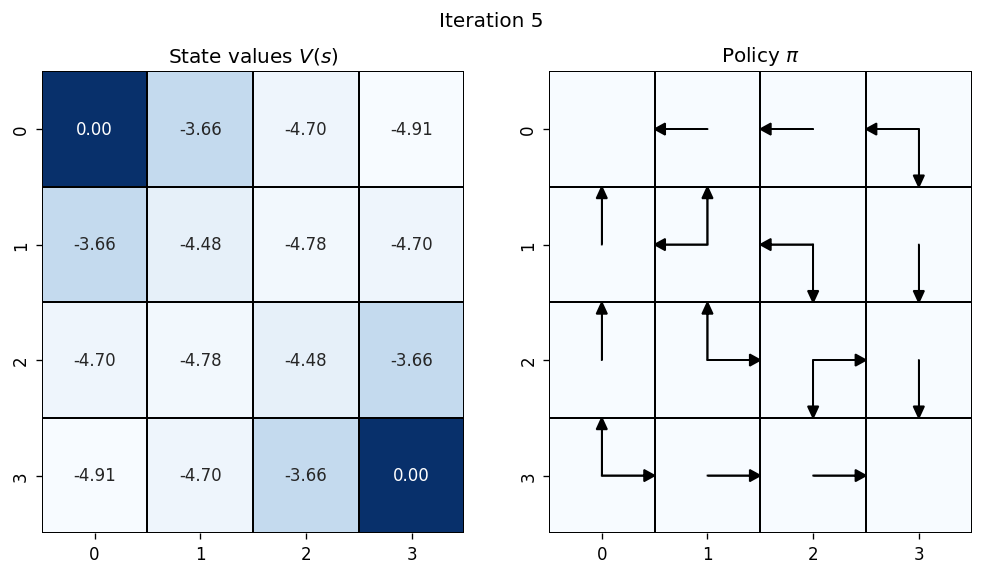

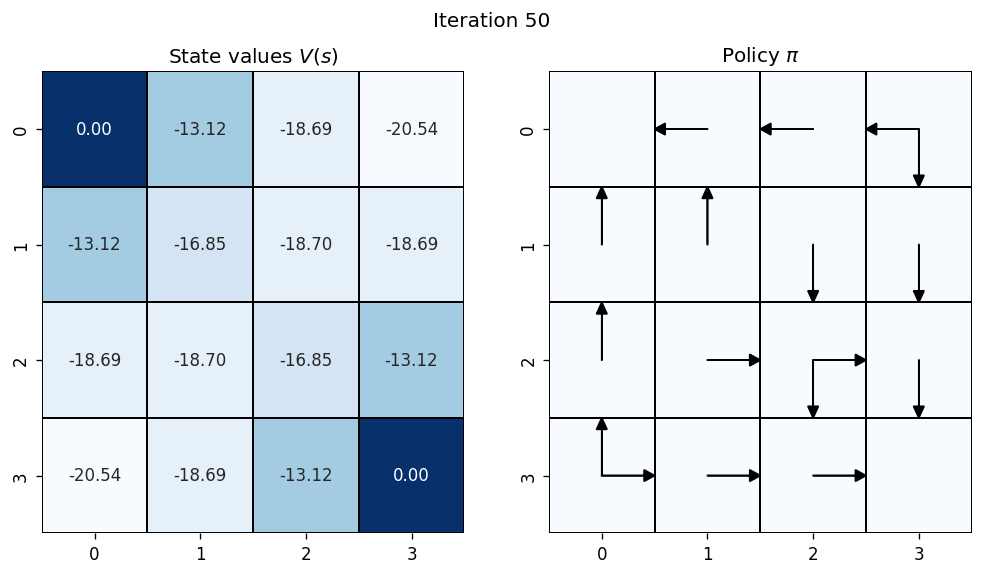

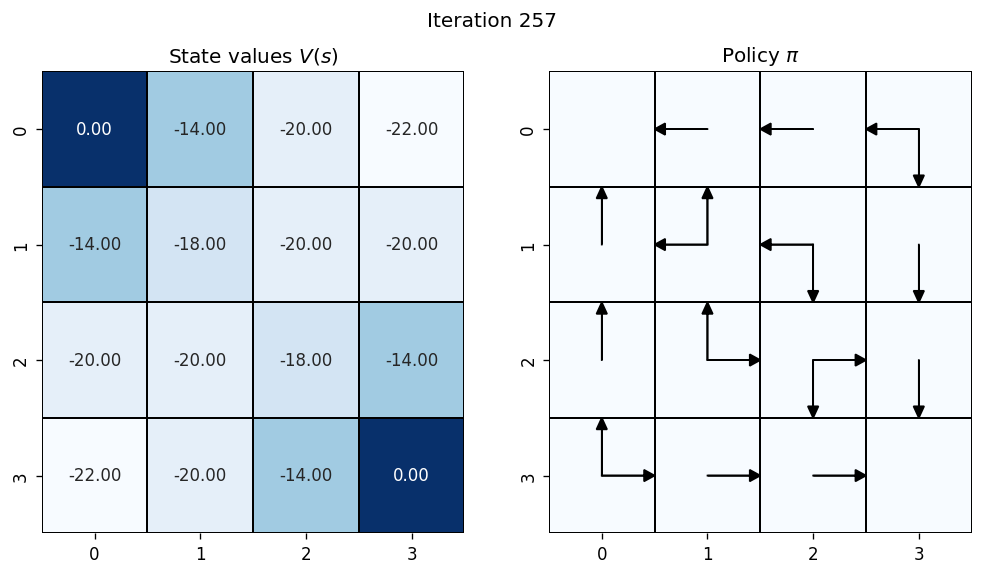

In [6]:
for idx in [0, 1, 2, 5, 50, sync_iteration]:
    f = draw_values_policy(grid_world, log_index=idx)
    f.savefig(f'../figs/grid_world_{idx}.png')